# Measured Data Reconstruction

This notebook demonstrates reconstructing a complex field using real-world, measured magnitude data. It involves loading measurement data, preprocessing it, potentially loading or creating a source point cloud, running holographic phase retrieval (Gerchberg-Saxton with perturbations), and visualizing the results.

## 1. Imports

Import necessary libraries: standard Python modules, numerical libraries (NumPy), configuration management (Hydra, OmegaConf), and custom modules for the phase retrieval algorithm, data loading, utility functions (smoothing, field reconstruction), and visualization.

In [1]:
import logging
import os
import pickle

import hydra
import numpy as np
from omegaconf import DictConfig, OmegaConf

# Assuming 'src' is in the Python path or the notebook is run from the project root
from src.algorithms.gerchberg_saxton import holographic_phase_retrieval
from src.create_channel_matrix import create_channel_matrix
from src.create_test_pointcloud import create_test_pointcloud
from src.io import load_measurement_data
from src.utils.field_utils import reconstruct_field
from src.utils.normalized_correlation import normalized_correlation  # Added import
from src.utils.normalized_rmse import normalized_rmse  # Added import
from src.utils.phase_retrieval_utils import apply_magnitude_constraint  # Added import
from src.utils.smoothing import (
    gaussian_convolution_local_support,
    physical_to_pixel_radius,
)
from src.visualization.field_plots import visualize_fields
from src.visualization.history_plots import (
    visualize_current_and_field_history,
    visualize_iteration_history,
)  # Added import

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("__notebook__")  # Use a notebook-specific logger name

## 2. Configuration Loading (Hydra)

Initialize Hydra within the notebook context to load the configuration for measured data reconstruction (`measured_data.yaml`).

**Important:** Adjust the `config_path` relative to where you run the notebook.

In [2]:
from hydra import compose, initialize

# Clear previous Hydra instances if necessary
hydra.core.global_hydra.GlobalHydra.instance().clear()

# Initialize Hydra
initialize(config_path="./conf", version_base="1.2")

# Compose the configuration
cfg = compose(config_name="measured_data")

# Print the configuration
logger.info("Loaded Configuration:")
print(OmegaConf.to_yaml(cfg))

INFO:__notebook__:Loaded Configuration:


wavelength: 0.0107
plane_size: 1.0
resolution: 149
room_size: 2.0
use_source_pointcloud: true
source_pointcloud_path: measurement_data/source_pointcloud.pkl
pointcloud_downsample: 4
max_distance_from_origin: -1
wall_points: 10
num_sources: 100
perturb_points: true
perturbation_factor: 0.05
amplitude_sigma: 3.0
gs_iterations: 200
convergence_threshold: 0.001
regularization: 0.001
adaptive_regularization: true
perturbation_mode: none
enable_perturbations: false
stagnation_window: 30
stagnation_threshold: 0.001
perturbation_intensity: 0.8
constraint_skip_iterations: 3
momentum_factor: 0.8
temperature: 5.0
verbose: false
return_history: true
show_plot: true
no_plot: false
no_anim: false
enable_smoothing: true
smoothing_radius_mm: 10.0



## 3. Helper Functions

Define helper functions used later in the notebook:
*   `create_measurement_plane`: Creates the 3D coordinates of the measurement plane based on the axes information in the loaded data, centering it at the origin.
*   `sample_measurement_data`: Downsamples the high-resolution measurement data to a target resolution specified in the config.
*   `downsample_pointcloud`: Reduces the number of points in the source point cloud by a given factor.

In [3]:
def create_measurement_plane(data):
    """
    Create measurement plane from continuous and discrete axes and convert to meters,
    ensuring the plane is centered at (0,0,0)
    """
    continuous_axis = data["continuous_axis"]
    discrete_axis = data["discrete_axis"]

    # Convert mm to m
    points_continuous = data["points_continuous"] / 1000.0
    points_discrete = data["points_discrete"] / 1000.0

    # Center the axes
    points_continuous_centered = points_continuous - np.mean(points_continuous)
    points_discrete_centered = points_discrete - np.mean(points_discrete)

    if continuous_axis == "z" and discrete_axis == "y":
        Z, Y = np.meshgrid(points_continuous_centered, points_discrete_centered)
        X = np.full_like(Z, 0.0)  # Assume measurement plane is at X=0 after centering
        measurement_plane = np.stack([X, Y, Z], axis=-1)
        logger.info(
            f"Created measurement plane centered at (0,0,0) with shape: {measurement_plane.shape}"
        )
        logger.info(f"Measurement plane type: YZ (fixed X at {X[0,0]:.4f} m)")
    # Add other potential axis combinations if needed
    # elif continuous_axis == "x" and discrete_axis == "y":
    #     X, Y = np.meshgrid(points_continuous_centered, points_discrete_centered)
    #     Z = np.full_like(X, 0.0)
    #     measurement_plane = np.stack([X, Y, Z], axis=-1)
    #     logger.info(f"Created measurement plane centered at (0,0,0) with shape: {measurement_plane.shape}")
    #     logger.info(f"Measurement plane type: XY (fixed Z at {Z[0,0]:.4f} m)")
    else:
        raise ValueError(
            f"Unsupported axes combination for measurement plane: continuous='{continuous_axis}', discrete='{discrete_axis}'"
        )

    return measurement_plane


def sample_measurement_data(data, target_resolution=50):
    """
    Sample measurement data to reduce dimensionality towards the target resolution.
    Creates approximately square output by sampling both axes.
    """
    results = data["results"]
    points_continuous = data["points_continuous"]
    points_discrete = data["points_discrete"]

    n_discrete = len(points_discrete)
    n_continuous = len(points_continuous)
    logger.info(f"Original data dimensions: {n_discrete} (discrete) × {n_continuous} (continuous)")

    # Determine target dimensions for sampling
    target_n_discrete = min(target_resolution, n_discrete)
    target_n_continuous = min(target_resolution, n_continuous)

    if target_n_discrete >= n_discrete and target_n_continuous >= n_continuous:
        logger.info("Target resolution is >= original resolution. No sampling needed.")
        return data

    logger.info(f"Target sampling dimensions: {target_n_discrete}×{target_n_continuous}")

    # Choose indices for sampling
    discrete_indices = np.linspace(0, n_discrete - 1, target_n_discrete, dtype=int)
    continuous_indices = np.linspace(0, n_continuous - 1, target_n_continuous, dtype=int)

    # Sample the data
    sampled_points_discrete = points_discrete[discrete_indices]
    sampled_points_continuous = points_continuous[continuous_indices]
    # Use np.ix_ for correct 2D indexing
    sampled_results = results[np.ix_(discrete_indices, continuous_indices)]

    logger.info(
        f"Sampled data dimensions: {len(sampled_points_discrete)}×{len(sampled_points_continuous)}"
    )

    # Create a new dictionary with sampled data
    sampled_data = data.copy()
    sampled_data["results"] = sampled_results
    sampled_data["points_discrete"] = sampled_points_discrete
    sampled_data["points_continuous"] = sampled_points_continuous

    return sampled_data


def downsample_pointcloud(points, factor):
    """
    Downsample a point cloud by the specified factor.
    """
    if factor <= 1:
        logger.info("Downsample factor <= 1, no point cloud downsampling performed.")
        return points

    downsampled_points = points[::factor]
    logger.info(
        f"Downsampled point cloud from {len(points)} to {len(downsampled_points)} points (factor: {factor})"
    )
    return downsampled_points

## 4. Setup Output Directory

Create a directory to store plots and results generated by this notebook.

In [4]:
# Define output directory
output_dir = "./plots_measured/"  # Changed path
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
logger.info(f"Output directory for plots and results: {output_dir}")

INFO:__notebook__:Output directory for plots and results: ./plots_measured/


## 5. Load or Create Point Cloud

Based on `cfg.use_source_pointcloud`:
*   If `True`: Load a point cloud from the specified pickle file (`cfg.source_pointcloud_path`).
    *   Downsample the point cloud using `cfg.pointcloud_downsample`.
    *   Apply a hardcoded translation (this might need adjustment or configuration).
    *   Optionally filter points based on maximum distance from the origin (`cfg.max_distance_from_origin`).
*   If `False`: Create a synthetic test point cloud (e.g., a cube) using `create_test_pointcloud`.

In [5]:
logger.info("Starting point cloud processing...")

points = None  # Initialize points
if cfg.use_source_pointcloud:
    logger.info(f"Loading source point cloud from {cfg.source_pointcloud_path}...")
    try:
        with open(cfg.source_pointcloud_path, "rb") as f:
            data = pickle.load(f)

        if isinstance(data, np.ndarray) and data.ndim == 2 and data.shape[1] >= 3:
            # 1. Downsample
            full_points = downsample_pointcloud(data, cfg.pointcloud_downsample)

            # 2. Translate (Consider making translation configurable)
            # This specific translation seems related to aligning the point cloud with the measurement setup
            translation = np.array(
                cfg.get("pointcloud_translation", [-5.35211, -6.34833, -1.28819])
            )  # Get from config or use default
            points_translated = full_points[:, :3] + translation
            logger.info(f"Translated point cloud by {translation} meters")

            # 3. Filter by distance
            max_dist = cfg.get("max_distance_from_origin", -1)  # Use .get for safer access
            if max_dist is not None and max_dist > 0:
                distances = np.sqrt(np.sum(points_translated**2, axis=1))
                orig_num_points = len(points_translated)
                points = points_translated[distances <= max_dist]
                logger.info(
                    f"Filtered out {orig_num_points - len(points)} points "
                    f"further than {max_dist}m from origin."
                )
                logger.info(f"Retained {len(points)} points.")
            else:
                points = points_translated  # Use all translated points if no filtering
                logger.info("No distance filtering applied.")

            logger.info(
                f"Using processed real data point cloud with {len(points)} points, shape: {points.shape}"
            )

        else:
            logger.error(
                f"Source point cloud data has unexpected type ({type(data)}) or shape ({data.shape if isinstance(data, np.ndarray) else 'N/A'})."
            )
            # Handle error: maybe raise, or fall back to test cloud

    except FileNotFoundError:
        logger.error(
            f"Error: Point cloud file not found at {cfg.source_pointcloud_path}. Check the path."
        )
    except Exception as e:
        logger.error(f"Error loading or processing point cloud: {e}")

else:
    logger.info("Creating test point cloud (e.g., cube environment)...")
    points = create_test_pointcloud(cfg)
    logger.info(f"Created test environment with {len(points)} points.")

if points is None:
    logger.error("Point cloud could not be loaded or created. Subsequent steps might fail.")
    # raise ValueError("Point cloud is required to proceed.")
else:
    logger.info("Finished point cloud processing.")

INFO:__notebook__:Starting point cloud processing...
INFO:__notebook__:Loading source point cloud from measurement_data/source_pointcloud.pkl...
INFO:__notebook__:Downsampled point cloud from 5328 to 1332 points (factor: 4)
INFO:__notebook__:Translated point cloud by [-5.35211 -6.34833 -1.28819] meters
INFO:__notebook__:No distance filtering applied.
INFO:__notebook__:Using processed real data point cloud with 1332 points, shape: (1332, 3)
INFO:__notebook__:Finished point cloud processing.


## 6. Load and Preprocess Measurement Data

Load the real measurement data from the specified pickle file (`measurement_file`).
*   Sample the data down to the target resolution using `sample_measurement_data`.
*   Create the corresponding measurement plane using `create_measurement_plane`.
*   Extract the measured magnitude, flatten it, and handle potential NaN values.

In [6]:
# Define the path to the measurement data file
# Consider making this path configurable via Hydra
measurement_file = cfg.get("measurement_data_path", "measurement_data/x400_zy.pickle")

measurement_data = None
sampled_data = None
measurement_plane = None
measured_magnitude = None
measured_magnitude_2d = None
resolution_y = None
resolution_z = None

try:
    logger.info(f"Loading measurement data from {measurement_file}...")
    measurement_data = load_measurement_data(measurement_file)

    # Sample the data
    logger.info(f"Sampling measurement data to target resolution: {cfg.resolution}...")
    sampled_data = sample_measurement_data(measurement_data, target_resolution=cfg.resolution)

    # Create measurement plane from sampled data
    logger.info("Creating measurement plane from sampled data...")
    measurement_plane = create_measurement_plane(sampled_data)

    # Extract and process measured magnitude
    measured_magnitude_2d = np.abs(sampled_data["results"])
    measured_magnitude = measured_magnitude_2d.flatten()

    # Handle potential NaNs (replace with minimum non-NaN value)
    if np.isnan(measured_magnitude).any():
        min_val = np.nanmin(measured_magnitude)
        measured_magnitude = np.nan_to_num(measured_magnitude, nan=min_val)
        measured_magnitude_2d = np.nan_to_num(measured_magnitude_2d, nan=min_val)
        logger.warning(f"Replaced NaN values in measured magnitude with {min_val:.4e}")

    resolution_y = measured_magnitude_2d.shape[0]
    resolution_z = measured_magnitude_2d.shape[1]
    logger.info(
        f"Processed measured magnitude. Shape: {measured_magnitude.shape}, 2D Shape: {measured_magnitude_2d.shape}"
    )

except FileNotFoundError:
    logger.error(f"Error: Measurement data file not found at {measurement_file}. Check the path.")
except Exception as e:
    logger.error(f"Error loading or processing measurement data: {e}")

if measurement_plane is None or measured_magnitude is None:
    logger.error("Measurement data/plane could not be processed. Subsequent steps might fail.")
    # raise ValueError("Measurement data is required.")

INFO:__notebook__:Loading measurement data from measurement_data/x400_zy.pickle...
INFO:__notebook__:Sampling measurement data to target resolution: 149...
INFO:__notebook__:Original data dimensions: 149 (discrete) × 2448 (continuous)
INFO:__notebook__:Target sampling dimensions: 149×149
INFO:__notebook__:Sampled data dimensions: 149×149
INFO:__notebook__:Creating measurement plane from sampled data...
INFO:__notebook__:Created measurement plane centered at (0,0,0) with shape: (149, 149, 3)
INFO:__notebook__:Measurement plane type: YZ (fixed X at 0.0000 m)
INFO:__notebook__:Processed measured magnitude. Shape: (22201,), 2D Shape: (149, 149)


## 7. Determine Wave Number (k)

Calculate the wave number `k`.
*   If using a source point cloud and configured to use the measurement frequency (`cfg.use_measurement_frequency`), calculate `k` based on the frequency stored in the measurement data.
*   Otherwise, calculate `k` based on the wavelength specified in the configuration (`cfg.wavelength`).

In [7]:
k = None
wavelength = None

try:
    # Check conditions carefully
    use_measurement_freq = (
        cfg.use_source_pointcloud
        and cfg.get("use_measurement_frequency", False)  # Use .get for safety
        and measurement_data is not None
        and "frequency" in measurement_data
    )

    if use_measurement_freq:
        frequency_ghz = measurement_data["frequency"] / 1e9
        # Speed of light in m/s
        c = 299792458
        wavelength = c / (frequency_ghz * 1e9)  # Wavelength in meters
        k = 2 * np.pi / wavelength
        logger.info(f"Using measurement frequency: {frequency_ghz:.2f} GHz")
        logger.info(f"Calculated wave number k: {k:.2f}, wavelength: {wavelength:.4f} m")
    elif "wavelength" in cfg:
        wavelength = cfg.wavelength
        k = 2 * np.pi / wavelength
        logger.info(f"Using config wavelength: {wavelength:.4f} m")
        logger.info(f"Calculated wave number k: {k:.2f}")
    else:
        logger.error(
            "Could not determine wave number k: Measurement frequency not used/available and wavelength not in config."
        )

except Exception as e:
    logger.error(f"Error calculating wave number k: {e}")

if k is None:
    logger.error("Wave number k could not be determined. Subsequent steps might fail.")
    # raise ValueError("Wave number k is required.")

INFO:__notebook__:Using config wavelength: 0.0107 m
INFO:__notebook__:Calculated wave number k: 587.21


## 8. Create Channel Matrix

Compute the channel matrix `H` that models the propagation from the source points (`points`) to the measurement plane (`measurement_plane`) using the calculated wave number `k`.

In [8]:
H = None
if points is not None and measurement_plane is not None and k is not None:
    logger.info("Creating channel matrix...")
    try:
        H = create_channel_matrix(points, measurement_plane, k)
        logger.info(f"Channel matrix H shape: {H.shape}")
    except Exception as e:
        logger.error(f"Error creating channel matrix: {e}")
else:
    logger.error(
        "Skipping channel matrix creation due to missing prerequisites (points, measurement_plane, or k)."
    )

if H is None:
    logger.error("Channel matrix H could not be created. Subsequent steps might fail.")
    # raise ValueError("Channel matrix H is required.")

INFO:__notebook__:Creating channel matrix...
INFO:__notebook__:Channel matrix H shape: (22201, 1332)


## 9. Initialize Field (Optional)

Optionally, create an initial guess for the field on the measurement plane. If `cfg.uniform_current_init` is true, initialize source currents with a uniform amplitude and random phase, compute the corresponding field using `H`, and then apply the measured magnitude constraint to this initial field.

In [9]:
initial_field_values = None
if (
    H is not None
    and points is not None
    and measured_magnitude is not None
    and cfg.get("uniform_current_init", False)
):
    logger.info(
        f"Initializing field from uniform currents (amplitude {cfg.initial_current_amplitude})..."
    )
    try:
        n_points = points.shape[0]
        random_phases = np.random.uniform(0, 2 * np.pi, n_points)
        initial_currents = cfg.initial_current_amplitude * np.exp(1j * random_phases)

        # Calculate field from these initial currents
        initial_field = H @ initial_currents

        # Apply the measured magnitude constraint
        initial_field_values = apply_magnitude_constraint(initial_field, measured_magnitude)
        logger.info(f"Initialized field values with shape {initial_field_values.shape}")
    except Exception as e:
        logger.error(f"Error during initial field calculation: {e}")
        initial_field_values = None  # Reset on error
else:
    logger.info("No initial field values provided or calculated.")

INFO:__notebook__:No initial field values provided or calculated.


## 10. Run Holographic Phase Retrieval

Execute the core phase retrieval algorithm (`holographic_phase_retrieval`) using the channel matrix `H`, the `measured_magnitude`, and the optional `initial_field_values`.

In [10]:
hpr_result = None
cluster_coefficients = None
coefficient_history = None
field_history = None
stats = None

if H is not None and measured_magnitude is not None:
    logger.info("Starting holographic phase retrieval...")
    try:
        hpr_result = holographic_phase_retrieval(
            cfg,
            H,
            measured_magnitude,
            initial_field_values=initial_field_values,  # Pass initial guess if available
            output_dir=output_dir,  # Pass output_dir if needed by HPR
        )
        logger.info("Finished holographic phase retrieval.")

        # Unpack results
        if cfg.return_history:
            cluster_coefficients, coefficient_history, field_history, stats = hpr_result
        else:
            cluster_coefficients, stats = hpr_result

    except Exception as e:
        logger.error(f"Error during holographic phase retrieval: {e}")

else:
    logger.error("Skipping phase retrieval due to missing prerequisites (H or measured_magnitude).")

if hpr_result is None:
    logger.error("Phase retrieval did not run successfully. Cannot proceed with analysis.")
    # raise ValueError("Phase retrieval failed.")

INFO:__notebook__:Starting holographic phase retrieval...


GS Progress: 100.0%


INFO:__notebook__:Finished holographic phase retrieval.


## 11. Log Perturbation Statistics

If the phase retrieval ran successfully, log the statistics returned, including iteration counts, RMSE values, and perturbation details (number applied, success rate, average improvement).

In [11]:
if stats is not None:
    logger.info("Perturbation statistics:")
    logger.info(f"  Total iterations: {stats.get('iterations', 'N/A')}")
    logger.info(f"  Final RMSE: {stats.get('final_rmse', float('nan')):.6f}")
    logger.info(f"  Best RMSE: {stats.get('best_rmse', float('nan')):.6f}")
    logger.info(f"  Perturbations applied: {stats.get('num_perturbations', 'N/A')}")

    # Check if post_perturbation_tracking exists and is not empty
    perturbation_tracking = stats.get("post_perturbation_tracking")
    if perturbation_tracking:  # Checks if it's not None and not empty
        successful_perturbations = [p for p in perturbation_tracking if p.get("success")]
        success_rate = len(successful_perturbations) / len(perturbation_tracking)

        # Calculate average improvement only if there are successful perturbations
        if successful_perturbations:
            improvements = [p.get("improvement", 0) for p in successful_perturbations]
            avg_improvement = np.mean(improvements)
        else:
            avg_improvement = 0

        logger.info(f"  Perturbation success rate: {success_rate:.2f}")
        logger.info(f"  Average improvement from successful perturbations: {avg_improvement:.6f}")
    else:
        logger.info("  No perturbation tracking data available.")
else:
    logger.warning("No statistics available from phase retrieval.")

INFO:__notebook__:Perturbation statistics:
INFO:__notebook__:  Total iterations: 200
INFO:__notebook__:  Final RMSE: 0.198029
INFO:__notebook__:  Best RMSE: 0.181978
INFO:__notebook__:  Perturbations applied: 0
INFO:__notebook__:  No perturbation tracking data available.


## 12. Reconstruct Final Field

Use the recovered `cluster_coefficients` and the channel matrix `H` to reconstruct the final complex field on the measurement plane.

In [12]:
reconstructed_field = None
reconstructed_field_2d = None

if (
    H is not None
    and cluster_coefficients is not None
    and resolution_y is not None
    and resolution_z is not None
):
    logger.info("Reconstructing final field from coefficients...")
    try:
        reconstructed_field = reconstruct_field(H, cluster_coefficients)
        # Reshape using the dimensions obtained during measurement data processing
        reconstructed_field_2d = reconstructed_field.reshape(resolution_y, resolution_z)
        logger.info(
            f"Reconstructed field shape: {reconstructed_field.shape}, 2D shape: {reconstructed_field_2d.shape}"
        )
    except Exception as e:
        logger.error(f"Error reconstructing final field: {e}")
else:
    logger.error("Skipping final field reconstruction due to missing prerequisites.")

if reconstructed_field is None:
    logger.error("Final field could not be reconstructed.")
    # raise ValueError("Final field reconstruction failed.")

INFO:__notebook__:Reconstructing final field from coefficients...
INFO:__notebook__:Reconstructed field shape: (22201,), 2D shape: (149, 149)


## 13. Define 'True' Field for Comparison

For measured data, we don't have a ground truth complex field. We typically use the *measured magnitude* itself as the reference ('true' field magnitude) for calculating comparison metrics like RMSE and correlation against the *magnitude* of the reconstructed field.

In [13]:
# Use the processed measured magnitude as the 'true' reference magnitude
if measured_magnitude is not None and measured_magnitude_2d is not None:
    true_field_magnitude = measured_magnitude.copy()
    true_field_magnitude_2d = measured_magnitude_2d.copy()
    logger.info("Using measured magnitude as the reference 'true' magnitude for comparison.")
else:
    logger.error("Measured magnitude is not available to be used as reference.")
    true_field_magnitude = None
    true_field_magnitude_2d = None

INFO:__notebook__:Using measured magnitude as the reference 'true' magnitude for comparison.


## 14. Apply Smoothing (Optional)

If `cfg.enable_smoothing` is true, apply Gaussian smoothing to both the reference ('true') magnitude field and the magnitude of the reconstructed field. This can help reduce noise and compare the overall shapes.

*   Calculate the smoothing radius in pixels from the physical radius (`cfg.smoothing_radius_mm`).
*   Apply `gaussian_convolution_local_support`.
*   **Note:** Smoothing is applied only to the magnitudes for comparison. The phase of the reconstructed field is preserved if smoothing is applied.

In [14]:
smoothing_applied = False
if (
    cfg.get("enable_smoothing", False)
    and true_field_magnitude_2d is not None
    and reconstructed_field_2d is not None
    and sampled_data is not None
):
    logger.info(f"Applying Gaussian smoothing with radius {cfg.smoothing_radius_mm} mm")
    try:
        # Calculate pixel radius
        R_pixels = physical_to_pixel_radius(
            cfg.smoothing_radius_mm,
            sampled_data["points_continuous"],  # Use sampled axes
            sampled_data["points_discrete"],
        )
        logger.info(
            f"Converted physical radius {cfg.smoothing_radius_mm} mm to pixel radius {R_pixels:.2f}"
        )

        # Smooth the 'true' magnitude (which is the measured magnitude)
        smoothed_true_magnitude_2d = gaussian_convolution_local_support(
            true_field_magnitude_2d, R_pixels
        )

        # Smooth the magnitude of the reconstructed field
        reconstructed_magnitude_2d = np.abs(reconstructed_field_2d)
        smoothed_reconstructed_magnitude_2d = gaussian_convolution_local_support(
            reconstructed_magnitude_2d, R_pixels
        )

        # Update the fields used for comparison metrics
        true_field_magnitude_2d = smoothed_true_magnitude_2d
        true_field_magnitude = true_field_magnitude_2d.flatten()

        # For visualization/saving, create a smoothed complex field by combining smoothed magnitude and original phase
        reconstructed_phase_2d = np.angle(reconstructed_field_2d)
        smoothed_reconstructed_field_2d = smoothed_reconstructed_magnitude_2d * np.exp(
            1j * reconstructed_phase_2d
        )
        # Update the main reconstructed field variables to the smoothed versions
        reconstructed_field_2d = smoothed_reconstructed_field_2d
        reconstructed_field = reconstructed_field_2d.flatten()

        smoothing_applied = True
        logger.info("Gaussian smoothing applied to reference and reconstructed magnitudes.")

    except Exception as e:
        logger.error(f"Error during smoothing: {e}")
else:
    logger.info("Smoothing not enabled or prerequisites missing.")

INFO:__notebook__:Applying Gaussian smoothing with radius 10.0 mm
INFO:__notebook__:Converted physical radius 10.0 mm to pixel radius 2.69
INFO:__notebook__:Gaussian smoothing applied to reference and reconstructed magnitudes.


## 15. Calculate Final Metrics

Calculate the final quality metrics (Normalized RMSE and Correlation) by comparing the reference magnitude (`true_field_magnitude`) with the magnitude of the (potentially smoothed) reconstructed field (`reconstructed_field`).

In [15]:
rmse = None
corr = None

if true_field_magnitude is not None and reconstructed_field is not None:
    logger.info("Calculating final reconstruction quality metrics...")
    try:
        # Compare magnitudes
        reconstructed_magnitude = np.abs(reconstructed_field)
        rmse = normalized_rmse(true_field_magnitude, reconstructed_magnitude)
        corr = normalized_correlation(true_field_magnitude, reconstructed_magnitude)

        logger.info(
            f"  Normalized RMSE (Magnitude vs {'Smoothed ' if smoothing_applied else ''}Reference): {rmse:.4f}"
        )
        logger.info(
            f"  Correlation (Magnitude vs {'Smoothed ' if smoothing_applied else ''}Reference): {corr:.4f}"
        )
    except Exception as e:
        logger.error(f"Error calculating final metrics: {e}")
else:
    logger.error("Skipping final metrics calculation due to missing data.")

INFO:__notebook__:Calculating final reconstruction quality metrics...
INFO:__notebook__:  Normalized RMSE (Magnitude vs Smoothed Reference): 0.0926
INFO:__notebook__:  Correlation (Magnitude vs Smoothed Reference): 0.6834


## 16. Save Results

Save the key results (points, coefficients, fields, stats, config, etc.) into a pickle file in the output directory.

In [16]:
results_dict = {
    # Ensure all potential keys exist, even if None
    "points": points,
    "cluster_coefficients": cluster_coefficients,
    "reconstructed_field": reconstructed_field,
    "reconstructed_field_2d": reconstructed_field_2d,
    "measured_magnitude": measured_magnitude,  # Original measured magnitude
    "measured_magnitude_2d": measured_magnitude_2d,
    "reference_magnitude_field": true_field_magnitude,  # Reference used for metrics (might be smoothed)
    "reference_magnitude_field_2d": true_field_magnitude_2d,
    "stats": stats,
    "config": cfg,
    "smoothing_applied": smoothing_applied,
    "final_rmse": rmse,
    "final_correlation": corr,
}

if smoothing_applied:
    results_dict["smoothing_radius_mm"] = cfg.smoothing_radius_mm
    # Add smoothed fields explicitly if needed, though they might overwrite the main ones above
    # results_dict["smoothed_reconstructed_field"] = reconstructed_field
    # results_dict["smoothed_reconstructed_field_2d"] = reconstructed_field_2d

# Add history if available
if cfg.return_history:
    results_dict["coefficient_history"] = coefficient_history
    results_dict["field_history"] = field_history

results_file_path = os.path.join(output_dir, "reconstruction_results.pkl")
try:
    with open(results_file_path, "wb") as f:
        pickle.dump(results_dict, f)
    logger.info(f"Results saved to {results_file_path}")
except Exception as e:
    logger.error(f"Error saving results to {results_file_path}: {e}")

INFO:__notebook__:Results saved to ./plots_measured/reconstruction_results.pkl


## 17. Generate Visualizations (Optional)

If plotting is enabled (`cfg.no_plot` is false):
*   Generate the final field comparison plot using `visualize_fields`.
If animations are also enabled (`cfg.no_anim` is false) and history was returned:
*   Generate the GS iteration history animation (`visualize_iteration_history`).
*   Generate the current and field history animation (`visualize_current_and_field_history`).

INFO:__notebook__:Starting visualization generation...
INFO:__notebook__:Generating final field comparison visualization...
INFO:src.visualization.field_plots:Saved visualization to plots_measured/field_visualization_YZ.png


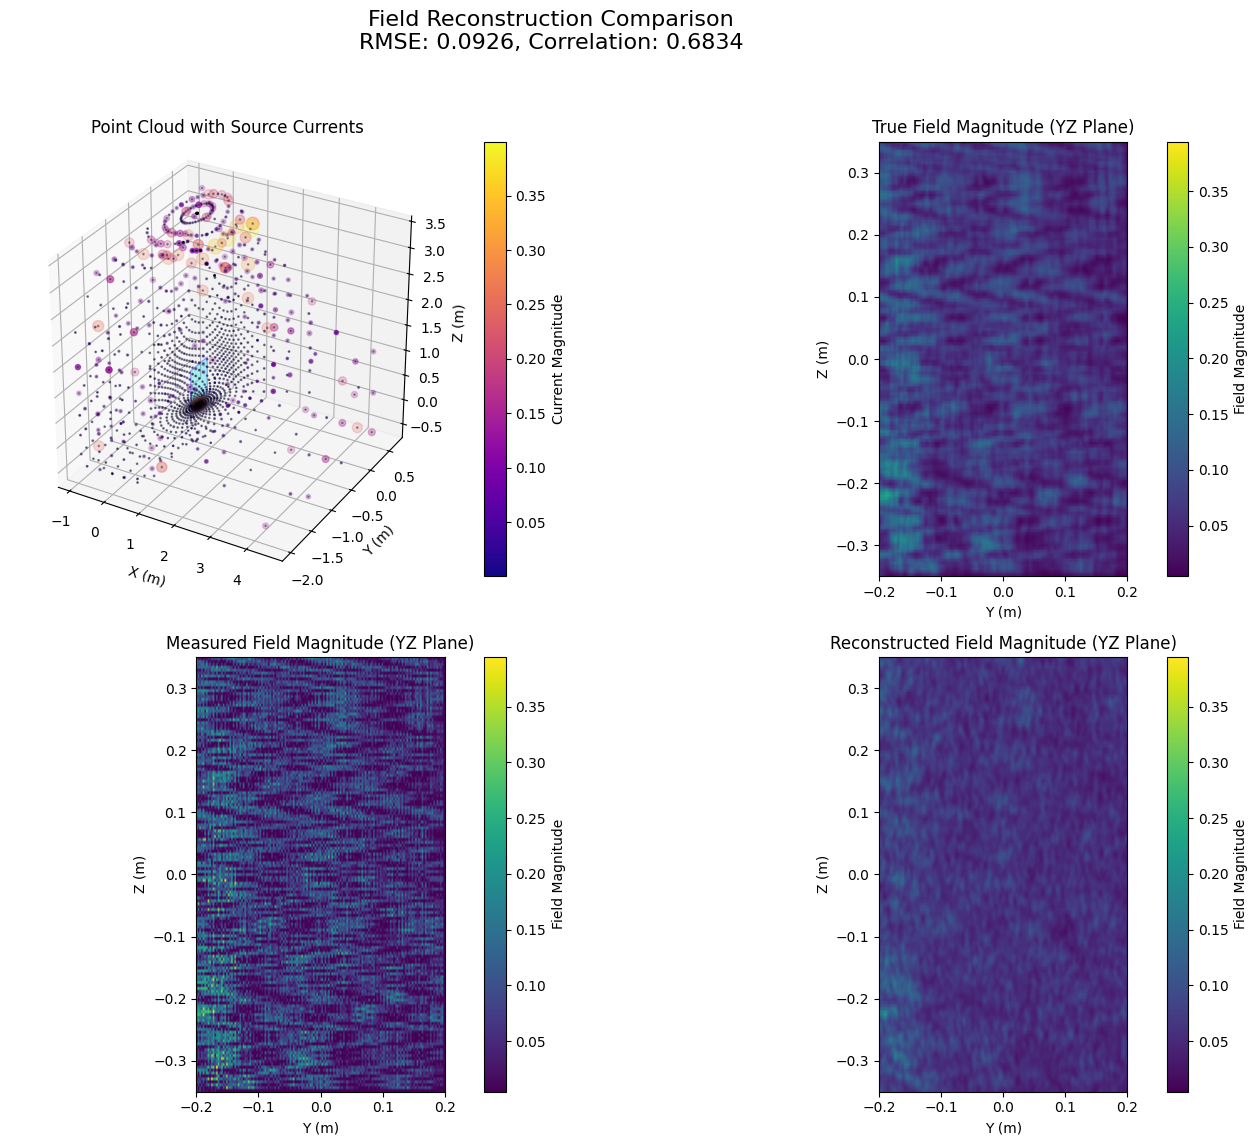

INFO:__notebook__:Final comparison plot saved in ./plots_measured/
INFO:__notebook__:Attempting to generate animations...
INFO:__notebook__:Creating GS iteration animation...


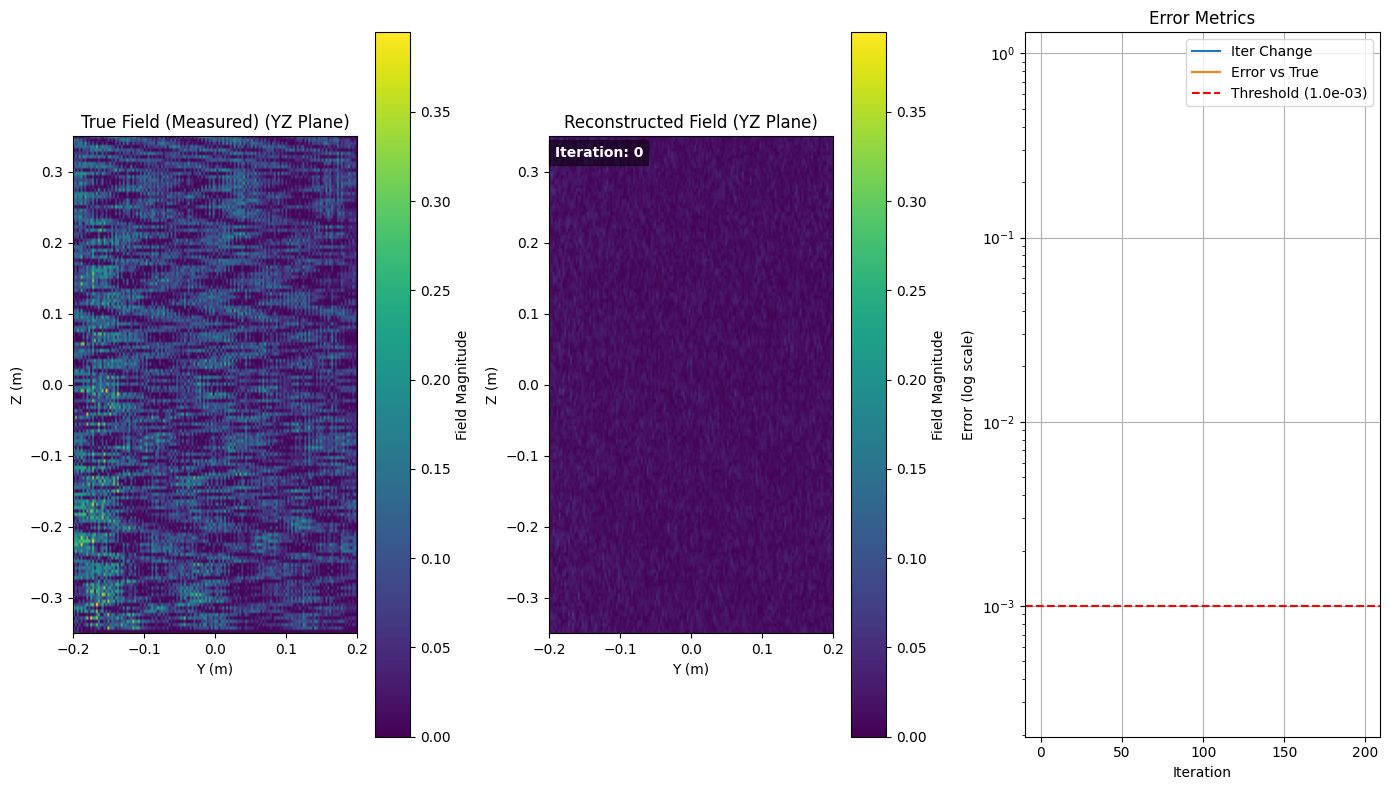

INFO:__notebook__:GS iteration animation saved to ./plots_measured/gs_animation.gif
INFO:__notebook__:Creating enhanced 4-panel animation...


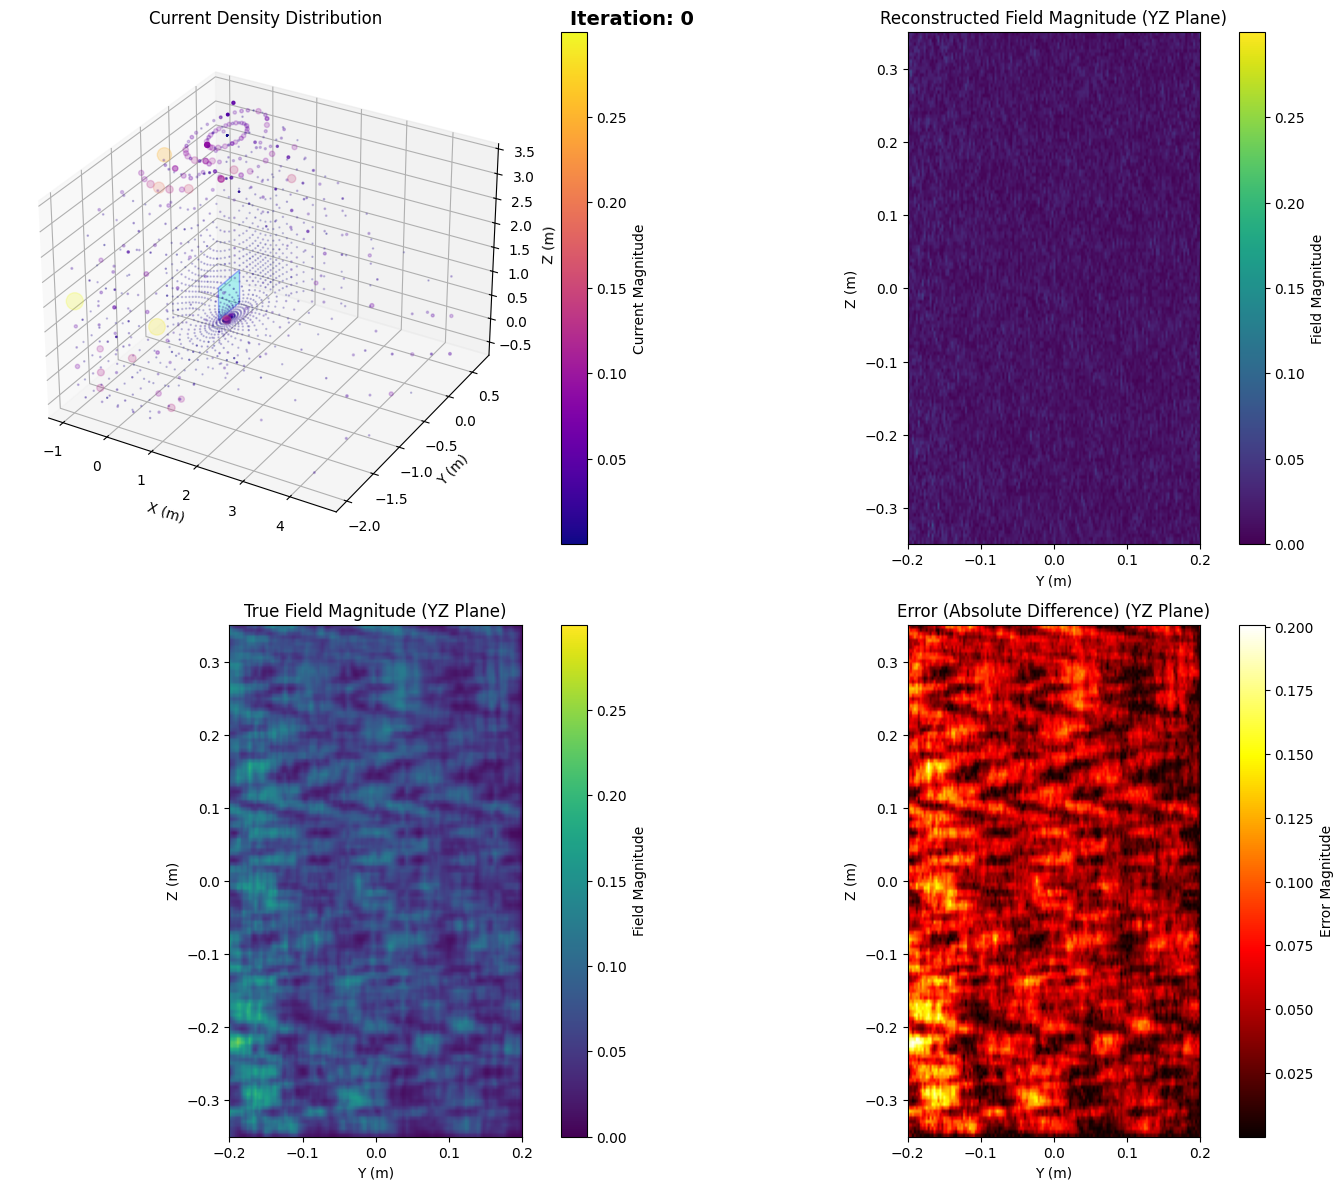

/home/codespace/.local/lib/python3.12/site-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(
INFO:__notebook__:Current/field animation saved to ./plots_measured/current_field_animation.gif
INFO:__notebook__:Finished visualization generation.


In [17]:
logger.info("Starting visualization generation...")

# Check if basic plotting is enabled
if not cfg.get("no_plot", False):
    logger.info("Generating final field comparison visualization...")
    # Check prerequisites for the plot
    plot_prereqs = [
        points,
        cluster_coefficients,  # Use reconstructed coefficients
        measurement_plane,
        true_field_magnitude_2d,  # Reference magnitude
        measured_magnitude_2d,  # Original measured magnitude
        reconstructed_field_2d,  # Final reconstructed field (complex)
        rmse,
        corr,
    ]
    if all(v is not None for v in plot_prereqs):
        try:
            visualize_fields(
                points,
                cluster_coefficients,  # Reconstructed currents/coefficients
                measurement_plane,
                true_field_magnitude_2d,  # Reference magnitude (potentially smoothed)
                measured_magnitude_2d,  # Original measured magnitude
                reconstructed_field_2d,  # Reconstructed complex field (potentially smoothed)
                rmse,
                corr,
                show_plot=cfg.get("show_plot", False),
                output_dir=output_dir,
            )
            logger.info(f"Final comparison plot saved in {output_dir}")
        except Exception as e:
            logger.error(f"Error generating final field plot: {e}")
    else:
        logger.warning("Skipping final field plot due to missing data.")

    # Check if animations are enabled and history is available
    if not cfg.get("no_anim", False) and cfg.return_history:
        logger.info("Attempting to generate animations...")
        # Check prerequisites for animations
        anim_prereqs = [
            points,
            H,
            coefficient_history,
            field_history,
            measurement_plane,
            measured_magnitude,  # Need original magnitude for GS anim error calc
            true_field_magnitude,  # Need reference magnitude for 4-panel anim
            stats,
        ]
        if (
            all(v is not None for v in anim_prereqs)
            and resolution_y is not None
            and resolution_z is not None
        ):
            # Determine resolution parameter (assuming square for now, might need adjustment)
            if resolution_y == resolution_z:
                resolution_param = resolution_y
            else:
                logger.warning(
                    f"Field dimensions are not square ({resolution_y}x{resolution_z}). Using first dimension for animation resolution."
                )
                resolution_param = resolution_y  # Or handle non-square case differently

            # GS Iteration Animation
            logger.info("Creating GS iteration animation...")
            try:
                visualize_iteration_history(
                    points,
                    H,
                    coefficient_history,
                    field_history,
                    resolution_param,
                    measurement_plane,
                    show_plot=cfg.get("show_plot", False),
                    output_file=None,  # Save directly
                    animation_filename=os.path.join(output_dir, "gs_animation.gif"),
                    frame_skip=cfg.get("anim_frame_skip", 1),
                    perturbation_iterations=stats.get("perturbation_iterations", []),
                    convergence_threshold=cfg.convergence_threshold,
                    measured_magnitude=measured_magnitude,
                )
                logger.info(
                    f"GS iteration animation saved to {os.path.join(output_dir, 'gs_animation.gif')}"
                )
            except Exception as e:
                logger.error(f"Error generating GS iteration animation: {e}")

            # Current and Field History Animation
            logger.info("Creating enhanced 4-panel animation...")
            try:
                visualize_current_and_field_history(
                    points,
                    coefficient_history,
                    field_history,
                    true_field_magnitude,  # Use reference magnitude for comparison panel
                    resolution_param,
                    measurement_plane,
                    show_plot=cfg.get("show_plot", False),
                    output_file=None,  # Save directly
                    animation_filename=os.path.join(output_dir, "current_field_animation.gif"),
                    frame_skip=cfg.get("anim_frame_skip", 1),
                )
                logger.info(
                    f"Current/field animation saved to {os.path.join(output_dir, 'current_field_animation.gif')}"
                )
            except Exception as e:
                logger.error(f"Error generating current/field animation: {e}")
        else:
            logger.warning(
                "Skipping animation generation due to missing history data or other prerequisites."
            )
    elif cfg.get("no_anim", False):
        logger.info("Animation generation disabled via no_anim flag.")
    elif not cfg.return_history:
        logger.info("History not returned by phase retrieval, skipping animations.")

elif cfg.get("no_plot", False):
    logger.info("Plot generation disabled via no_plot flag.")

logger.info("Finished visualization generation.")

## End of Notebook